# augmentation 기법을 적용해 ResNet-50을 학습


**텐서플로우의 랜덤 augmentation API를 사용해 보고, 최신
augmentation 기법을 익힌 뒤, 훈련 데이터셋의 augmentation 적용 여부에 따라 모델의 성능이 달라지는지 비교해 보겠습니다.**

<br>

### 실습목표

- Augmentation을 모델 학습에 적용하기
- Augmentation의 적용을 통한 학습 효과 확인하기

- 최신 data augmentation 기법 구현 및 활용하기

<br>

### 학습 내용

1. Augmentation 적용 (1) 데이터 불러오기
2. Augmentation 적용 (2) Augmentation 적용하기
3. Augmentation 적용 (3) 비교 실험하기
4. 심화 기법 (1) Cutmix Augmentation
5. 심화 기법 (2) Mixup Augmentation

## 데이터 불러오기


augmentation을 텐서플로우 모델 학습에 어떻게 적용할 수
있는지 공부하겠습니다. 

지금까지 모델을 훈련시키기 전, 데이터를 전처리해
입력값으로 사용해 오셨을 것입니다. 

Augmentation도 이처럼 입력 이미지의 데이터를 변경해 주는 과정이므로 일반적인 이미지 데이터 전처리 방법과
활용방법이 동일합니다. 

In [1]:
#필요한 라이브러리
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
print('=3')


=3


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

사용할 데이터셋을 불러옵니다. 

이번 시간에는 데이터셋을 사용해보도록 합시다. 

데이터셋에는 120개 견종의 이미지가 포함되어 있습니다. 

총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋입니다.

https://www.tensorflow.org/datasets/catalog/stanford_dogs

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
'stanford_dogs',
split=['train', 'test'],
shuffle_files=True,
with_info=True,
)
print('=3')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete776JL0/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incomplete776JL0/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
=3


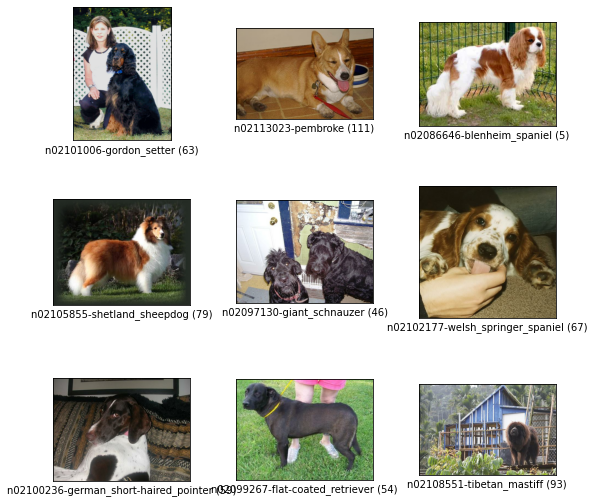

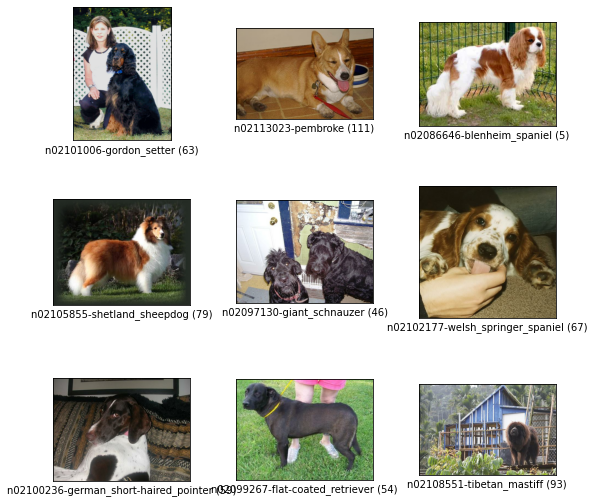

In [4]:
tfds.show_examples(ds_train, ds_info)


## Augmentation 적용하기

**텐서플로우 Random Augmentation API 사용하기**

많은 augmentation 기법들이 있지만 그중에서 텐서플로우 API로 바로 사용할 수 있는 방법들을 먼저 적용해 보겠습니다. 

먼저 이미지셋에 대해서 랜덤한 확률로 바로 적용할 수 있는 augmentation 함수들은 아래와 같습니다.

- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

In [5]:
def normalize_and_resize_img(image, label):
# Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


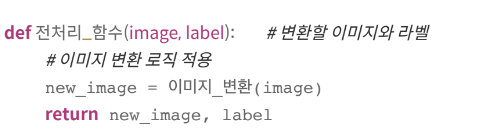

이렇게 되면 이미지 변환의 결과로 리턴 받은 이미지를 그다음 전처리 함수의 입력으로 연거푸 재사용할 수 있는 구조가 되어 편리합니다. 

위에서 만든 기본적인 전처리 함수도 위와 같은 구조를 가지고 있습니다.


이 함수는 입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize합니다. 

이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용될 것입니다.


맨 위에서 언급한 random augmentation들 중에서 random_flip_left_right()과 random_brightness() 를 활용해 보겠습니다. 

"flip"의 경우 좌우 대칭을 해줍니다. 예컨대 이미지 분류
문제에서 개 이미지는 좌우를 대칭하더라도 문제가 생기지 않습니다. 

따라서 좌우대칭의 적용을 통해 데이터를 늘릴 수 있도록 합니다. 

여기서 상하 대칭은 테스트 데이터셋의 이미지를 생각해 볼 때 위아래가 뒤집힌 사진이 없으므로 도움이 되지 않을 것이라 적용하지 않습니다. 

또 "brightness"를 조절하여 다양한 환경에서 얻어진 이미지에 대응할 수 있도록 하겠습니다.

In [6]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label
print('=3')

=3


오늘의 Augmentation을 통해 원본 데이터셋에 다양한 형태의 가공한 형태의 새로운 데이터셋을 얻게 되는 모든 과정을 구현한 메인 함수를 apply_normalize_on_dataset()로 정의하겠습니다.

여기서는 apply_normalize_on_dataset()를 통해서 일반적인 전처리 과정, 즉 normalize, resize, augmentation과 shuffle을 적용하도록 하겠습니다.

이때, 주의할 점은 shuffle이나 augmentation은 테스트 데이터셋에는 적용하지 않아야 한다는 점입니다.


여러 결과를 조합하기 위한 앙상블 방법 중 하나로 테스트 데이터셋에 augmentation을 적용하는 test-time augmentation이라는 방법이 있습니다.


https://hwiyong.tistory.com/215

<br>

코드에서는 이후에 수행할 비교실험을 위해서 with_aug 매개변수를 통해 augmentation의 적용여부를 결정할 수 있도록 하겠습니다.

https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map



In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
normalize_and_resize_img, # 기본적인 전처리 함수 적용
num_parallel_calls=2
)
    if not is_test and with_aug:
        ds = ds.map(
augment, # augment 함수 적용
num_parallel_calls=2
)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds
print('=3')

=3


**Random Augmentation 직접 구현하기**


위에서는 미리 구현된 random augmentation을 적용하도록 augment() 함수를 작성했습니다.

이번에는 tf.image의 다양한 함수들을 이용해서 직접 다양한 augmentation 기법을 랜덤하게 적용하는 augment2() 함수를 작성해보세요.

In [8]:
# make random augment function
def augment2(image,label):
    image = tf.image.central_crop(image, np.random.uniform(0.50, 1.00))
    image = tf.image.resize(image, [224, 224])
    return image, label

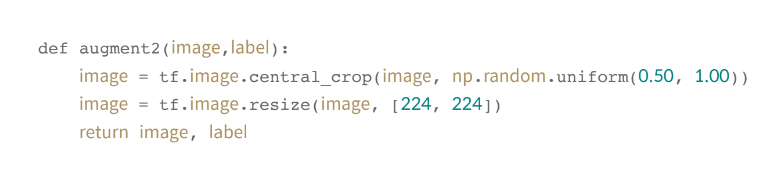

## Augmentation 적용: 비교실험 하기

우리가 비교해야 하는 것은 augmentation을 적용한
데이터를 학습시킨 모델과 적용하지 않은 데이터를 학습시킨 모델의 성능입니다. 

새로운 augmentation이 떠오르셨다면 새로운 함수로 augmentation한 데이터와 아닌 데이터를 학습시켜서 어떤 효과가 있는지 실험을 통해 알아볼 수도 있습니다.


아래 코드는 텐서플로우 케라스의 ResNet50 중 imagenet 으로 훈련된 모델을 불러옵니다.


include_top은 마지막 fully connected layer를 포함할지 여부입니다. 

해당 레이어를 포함하지 않고 생성하면 특성 추출기(feature extractor) 부분만 불러와 우리의 필요에 맞게 수정된 fully connected layer를 붙여서 활용할 수 있습니다. 

이렇게 하는 이유는 이미지넷 (ImageNet)과 우리의 테스트셋이 서로 다른 클래스를 가지므로, 마지막에 추가해야 하는 fully
connected layer의 구조(뉴런의 개수) 또한 다르기 때문입니다.

In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
keras.applications.resnet.ResNet50(
include_top=False,
weights='imagenet',
input_shape=(224,224,3),
pooling='avg',
),
keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

94781440/94765736 [==============================] - 1s 0us/step
=3


In [10]:
#Augmentation을 적용한 데이터셋으로 학습시킬 ResNet을 하나 더 만들어준다

aug_resnet50 = keras.models.Sequential([
keras.applications.resnet.ResNet50(
include_top=False,
weights='imagenet',
input_shape=(224,224,3),
pooling='avg',
),
keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [11]:
"""
텐서플로우 데이터셋에서 불러온 데이터에 하나는 apply_normalize_on_dataset()에서 with_aug
를 False로 주어 augmentation이 적용되지 않도록 하고, 다른 하나는 True로 주어 augmentation이 적용되도록 합니다.
"""


(ds_train, ds_test), ds_info = tfds.load(
'stanford_dogs',
split=['train', 'test'],
as_supervised=True,
shuffle_files=True,
with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


### 두 개 모델에 각각 augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋을 학습시키고, 검증을 진행합니다.

아래 학습은 EPOCH=20으로 진행시 GPU 기반으로 3~4시간 가량의 시간이 소요됩니다.

Augmentation 적용 효과를 명확히 검증하기 위해서는 최소 이정도의 학습이 진행되어야 하지만, 원활한 학습 진행을 위해서 EPOCH=3 정도로 진행해 보기를 권합니다. 

하지만 실제 프로젝트 단계에서는 꼭 충분한 학습이 진행되어야 합니다.

In [12]:
#EPOCH = 20 # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 3
resnet50.compile(
loss='sparse_categorical_crossentropy',
optimizer=tf.keras.optimizers.SGD(lr=0.01),
metrics=['accuracy'],
)


history_resnet50_no_aug = resnet50.fit(
ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
validation_steps=int(ds_info.splits['test'].num_examples/16),
epochs=EPOCH,
validation_data=ds_test,
verbose=1,
use_multiprocessing=True,
)

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


750/750 [==============================] - 179s 210ms/step - loss: 2.2084 - accuracy: 0.4467 - val_loss: 3.7935 - val_accuracy: 0.1419
Epoch 2/3
750/750 [==============================] - 156s 208ms/step - loss: 0.6881 - accuracy: 0.8121 - val_loss: 1.1707 - val_accuracy: 0.6572
Epoch 3/3
750/750 [==============================] - 156s 208ms/step - loss: 0.1971 - accuracy: 0.9625 - val_loss: 0.9393 - val_accuracy: 0.7287


In [13]:
aug_resnet50.compile(
loss='sparse_categorical_crossentropy',
optimizer=tf.keras.optimizers.SGD(lr=0.01),
metrics=['accuracy'],
)
history_resnet50_aug = aug_resnet50.fit(
ds_train_aug, # augmentation 적용한 데이터셋 사용
steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
validation_steps=int(ds_info.splits['test'].num_examples/16),
epochs=EPOCH,
validation_data=ds_test,
verbose=1,
use_multiprocessing=True,
)

Epoch 1/3
750/750 [==============================] - 168s 210ms/step - loss: 2.2595 - accuracy: 0.4297 - val_loss: 2.9915 - val_accuracy: 0.2633
Epoch 2/3
750/750 [==============================] - 156s 208ms/step - loss: 0.9715 - accuracy: 0.7198 - val_loss: 1.2713 - val_accuracy: 0.6281
Epoch 3/3
750/750 [==============================] - 156s 209ms/step - loss: 0.5547 - accuracy: 0.8417 - val_loss: 1.2367 - val_accuracy: 0.6445


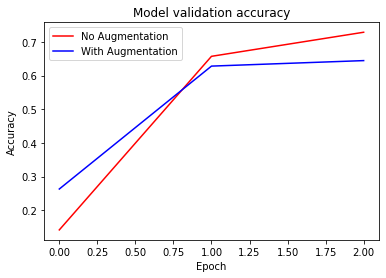

In [14]:
#시각화
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.show()

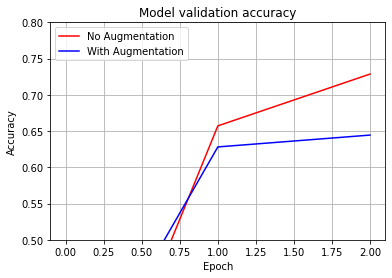

In [15]:
#확대

plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80) # 출력하고자 하는 Accuracy 범위를 지정해 주세요.
#plt.ylim(0.72, 0.76) # EPOCH=20으로 진행한다면 이 범위가 적당합니다.
plt.show()

참고로, 으로 수행해 본 두 모델의 훈련 과정 시각화한 내용은 아래 그림과 같습니다.


Augmentation 적용한 경우가 보다 천천히 학습되지만, EPOCH 10을 전후해서 aug_resnet50의 accuracy가 더 높게 형성되는 것을 확인할 수 있습니다.

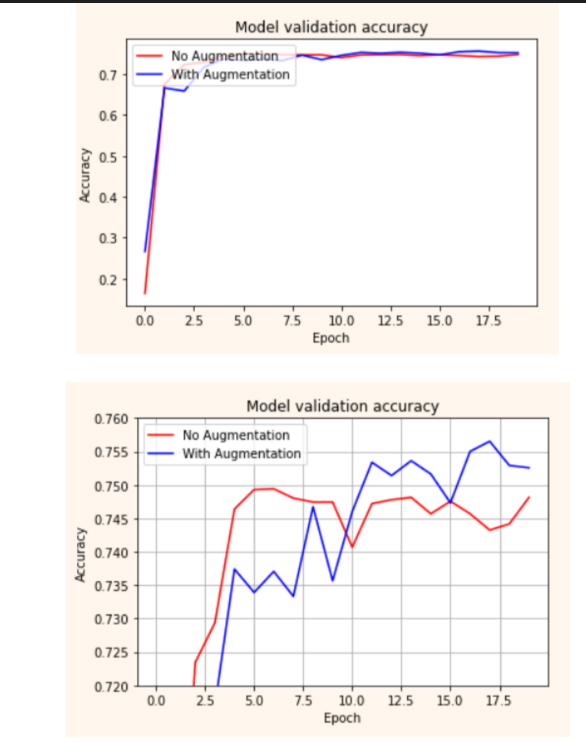